## Cancer Detection with Simple CNN Model

In [1]:
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Data Intake

## Helper Functions

Below are a list of helper functions used in the intake of the data. As part of the EDA I would like to see a couple of the images in the dataset. I would like to see the train/test split as well as the distribution of the labels. I also know that should reduce the size of the images to 32x32 as that is the space the pictures were evaluated within to see assign their labels. 

In [2]:
# Function to load and display images with labels
def display_images(image_ids, labels, directory, title):
    plt.figure(figsize=(10, 10))
    for i, (image_id, label) in enumerate(zip(image_ids[:10], labels[:10])):  # Display first 9 images
        image_path = os.path.join(directory, f"{image_id}.tif")
        try:
            img = Image.open(image_path)
            plt.subplot(2, 10//2, i+1, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f'{title} Image {i+1}\nLabel: {label}')
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    plt.tight_layout()
    plt.show()

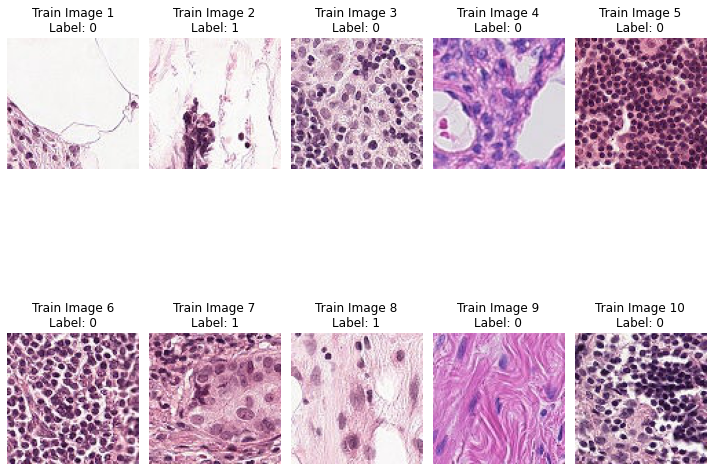

0    130908
1     89117
Name: label, dtype: int64


In [3]:
# Define the path to the train labels CSV file
csv_file_path = r'MSDS\DL\histopathologic-cancer-detection\train_labels.csv'

# Load the train labels CSV file
train_df = pd.read_csv(csv_file_path)

# Directories
train_dir = r'MSDS\DL\histopathologic-cancer-detection\train'
test_dir = r'MSDS\DL\histopathologic-cancer-detection\test'

# Get the first couple IDs and their corresponding labels from the train labels CSV file
sample_ids = train_df['id'].head(10).tolist()
sample_labels = train_df['label'].head(10).tolist()

# Display some train images with their labels
display_images(sample_ids, sample_labels, train_dir, 'Train')

label_count = train_df['label'].value_counts()
print(label_count)

In [4]:
# Count and print the number of images in each directory
# Get all image IDs from the train and test directories
train_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(train_dir, '*.tif'))]
test_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(test_dir, '*.tif'))]

num_train_images = len(train_image_ids)
num_test_images = len(test_image_ids)

print(f"Number of images in the train directory: {num_train_images}")
print(f"Number of images in the test directory: {num_test_images}")

label_count = train_df['label'].value_counts()
print('The count for each label in the training set is:')
print(label_count)

Number of images in the train directory: 220025
Number of images in the test directory: 57458
The count for each label in the training set is:
0    130908
1     89117
Name: label, dtype: int64


The model is fairly balanced and I know I am reading the images in correctly as I was able to print out and view some of the images in here. 

## Preprocessing

I Want to augment the images and then crop them. Per the data source, the space reviewed for cancer was on 32x32 in the center of the image. However, several notebooks submitted on kaggle found out that the model performed better when you allowed for a larger image to be put in. I have chosen 64x64 after some testing to determine an seemingly good size of image for the model. 

## Helper Functions

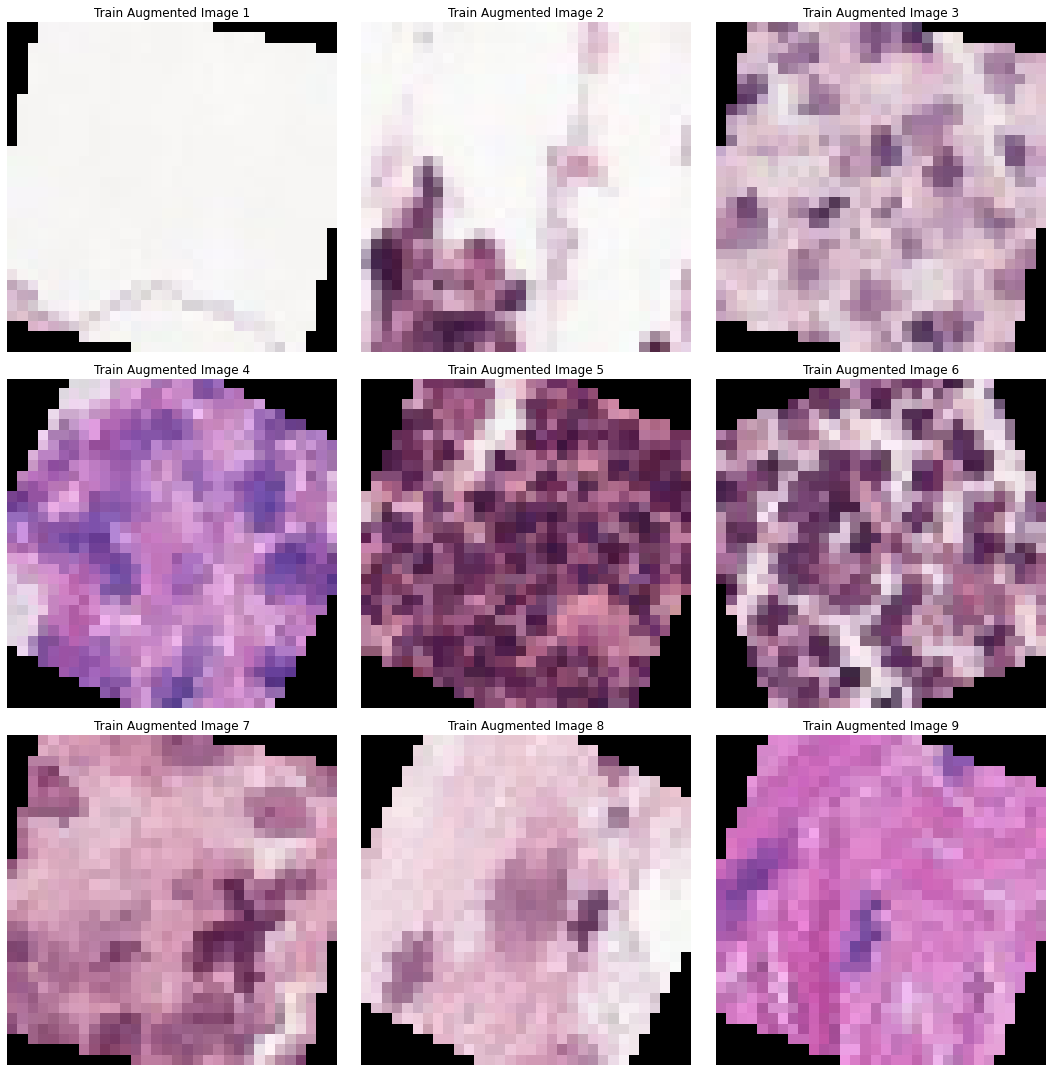

In [5]:
# Define transformations for the training and validation sets

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Define the path to the train labels CSV file
csv_file_path = r'MSDS\DL\histopathologic-cancer-detection\train_labels.csv'

# Load the train labels CSV file
train_df = pd.read_csv(csv_file_path)

# Directories
train_dir = r'MSDS\DL\histopathologic-cancer-detection\train'

# Define the custom dataset class
class CancerDataset(Dataset):
    def __init__(self, datafolder, image_ids, transform=None, labels_dict={}):
        self.datafolder = datafolder
        self.image_ids = image_ids
        self.transform = transform
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels_dict.get(self.image_ids[idx], 0)
        return image, label

# Sample image IDs for testing
sample_image_ids = train_df['id'].head(9).tolist()

# Instantiate a temporary dataset for visualization purposes
sample_dataset = CancerDataset(datafolder=train_dir, image_ids=sample_image_ids, transform=train_transform)

def display_augmented_images(dataset, title):
    plt.figure(figsize=(15, 15))
    for i in range(len(dataset)):  # Display all images in the sample_dataset
        try:
            img, _ = dataset[i]  # Get transformed image
            img = img.permute(1, 2, 0).numpy()  # Change dimensions to (H, W, C) for display
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(f'{title} Augmented Image {i+1}')
            plt.axis('off')
        except Exception as e:
            print(f"Error loading or augmenting image {i}: {e}")
    plt.tight_layout()
    plt.show()

# Display augmented train images
display_augmented_images(sample_dataset, 'Train')


# Modeling

## Simple CNN Model

In [ ]:
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

My first attempt at training a model will begin with a simple CNN model. I want the model to be simple enough to understand so that I can work with it to see improvements. My goal is not efficency but I will be measuring accuracy and loss vs Epoch to determine success. While I do not have a set goal for accuracy, seeing an 80% or higher success rate would be what I would consider a success for this project. 

The model is a Covulutional Nueral Network with 3 convuluation layersand two fully connected layers. The activation function used is ReLu. The forward pass utilizes max pooling to approximate an output and drop out is implemented to prevent overfitting. The hyperparameters are set at the top for ease of reference.

Epoch [1/12], Step [1/6189], Loss: 0.6893
Epoch [1/12], Step [1001/6189], Loss: 0.5637
Epoch [1/12], Step [2001/6189], Loss: 0.7460
Epoch [1/12], Step [3001/6189], Loss: 0.6006
Epoch [1/12], Step [4001/6189], Loss: 0.3992
Epoch [1/12], Step [5001/6189], Loss: 0.6215
Epoch [1/12], Step [6001/6189], Loss: 0.6884
Epoch [1/12], Train Loss: 0.5096, Val Loss: 0.4595
Epoch [1/12], Train Accuracy: 76.01%, Val Accuracy: 78.83%
Epoch [2/12], Step [1/6189], Loss: 0.4538
Epoch [2/12], Step [1001/6189], Loss: 0.3838
Epoch [2/12], Step [2001/6189], Loss: 0.5466
Epoch [2/12], Step [3001/6189], Loss: 0.5034
Epoch [2/12], Step [4001/6189], Loss: 0.3492
Epoch [2/12], Step [5001/6189], Loss: 0.4458
Epoch [2/12], Step [6001/6189], Loss: 0.4695
Epoch [2/12], Train Loss: 0.4793, Val Loss: 0.4442
Epoch [2/12], Train Accuracy: 77.93%, Val Accuracy: 79.35%
Epoch [3/12], Step [1/6189], Loss: 0.5613
Epoch [3/12], Step [1001/6189], Loss: 0.2708
Epoch [3/12], Step [2001/6189], Loss: 0.5949
Epoch [3/12], Step [3001

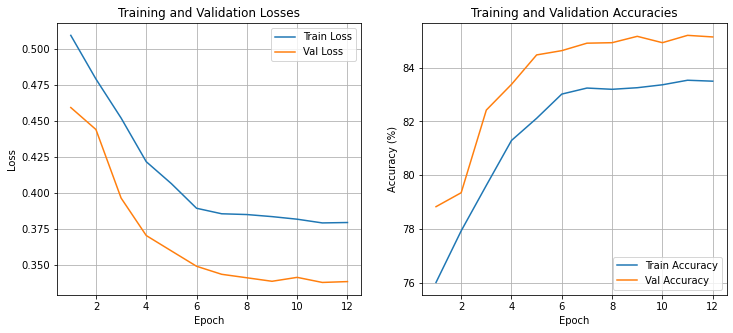

In [9]:
# Hyperparameters
batch_size = 32
learning_rate = 0.0001
num_epochs = 12
early_stopping_patience = 3
print_freq = 1000  # Frequency of printing progress
dropout_prob = 0.5
step_size = 5
gamma = 0.1

# CNN architecture with dropout and three convolutional layers
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Added third convolutional layer
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout with 50% probability

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))  # Forward pass through third conv layer
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

# Define transformation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Define the path to the train labels CSV file
csv_file_path = r'MSDS\DL\histopathologic-cancer-detection\train_labels.csv'

# Load the train labels CSV file
train_df = pd.read_csv(csv_file_path)

# Create a dictionary of labels from the DataFrame
labels_dict = {row['id']: row['label'] for idx, row in train_df.iterrows()}

# Define the directories
train_dir = r'MSDS\DL\histopathologic-cancer-detection\train'

# Get all image IDs from the train directory
train_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(train_dir, '*.tif'))]

# Split the train data into train and validation sets
train_ids, val_ids = train_test_split(train_image_ids, test_size=0.1, random_state=42)

# CancerDataset class
class CancerDataset(Dataset):
    def __init__(self, datafolder, image_ids, transform=None, labels_dict={}):
        self.datafolder = datafolder
        self.image_ids = image_ids
        self.transform = transform
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        label = self.labels_dict.get(self.image_ids[idx], 0)
        return image, label

# Instantiate datasets
train_dataset = CancerDataset(datafolder=train_dir, image_ids=train_ids, transform=train_transform, labels_dict=labels_dict)
val_dataset = CancerDataset(datafolder=train_dir, image_ids=val_ids, transform=val_transform, labels_dict=labels_dict)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Instantiate the model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Reduce LR by a factor of 0.1 every 5 epochs

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)  # Multiply by batch size
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if i % print_freq == 0:  # Print progress every print_freq batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)  # Multiply by batch size
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print and store losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    
    # Step the learning rate scheduler
    scheduler.step()

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plotting the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Losses')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracies')
ax2.legend()
ax2.grid(True)

plt.show()


After several manual iterations, I landed on the above model. With a Validation Accuracy of 85%, a Train Loss: 0.3797, Val Loss: 0.3386. I am satisfied with this output but believe I still have a lot to learn as I sort of hit a wall. It appears the most successful models on kaggle for this project are pre trained models tuned to the dataset. This process however has taught me that a lot of this is very intuitive as long as you apply basic physics to the theory of it. While complicated to implement, maintaing some of the theory during implementation allwoed me to "visualise" what was happening under the hood with each tweak to the hyper parameters. 

## Testing and Result

My kaggle submission achieved a public score of 80%.

In [10]:
import pandas as pd
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

# hyperparameters
batch_size = 32

# Define transformation for test images (only resizing)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Define the test directory
test_dir = r'MSDS\DL\histopathologic-cancer-detection\test'

# Get all image IDs from the test directory
test_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(test_dir, '*.tif'))]

# Define TestDataset class
class TestDataset(Dataset):
    def __init__(self, datafolder, image_ids, transform=None):
        self.datafolder = datafolder
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image, self.image_ids[idx]

# Instantiate the test dataset
test_dataset = TestDataset(datafolder=test_dir, image_ids=test_image_ids, transform=test_transform)

# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN architecture with dropout and three convolutional layers
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv3(x))  
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Dictionary to store predictions
predictions = []

# Test phase
with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for image_id, prediction in zip(image_ids, predicted):
            predictions.append({'id': image_id, 'label': prediction.item()})

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Save predictions to a CSV file
output_file = r'MSDS\DL\histopathologic-cancer-detection\Submission.csv')
predictions_df.to_csv(output_file, index=False)
